# RBF - Lista de Exercícios

### Importação e carregamento dos dados

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

# 1. Carregar os dados
data = load_breast_cancer()
X = data.data
y = data.target


Verificando se tem nulos. Acho que no python esse dataset ja vem sem nulos.

In [11]:

np.isnan(X).any()


np.False_

Primeiro vou fazer para K = 10

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [41]:
K = 10
erros = []
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(X_train)
    centros = kmeans.cluster_centers_

    dists = []
    for i in range(K):
        for j in range(i + 1, K):
            dist = np.linalg.norm(centros[i] - centros[j])
            dists.append(dist)
    sigma = np.mean(dists)

    n_train = X_train.shape[0]
    Phi_train = np.zeros((n_train, K))
    for i in range(n_train):
        for j in range(K):
            dist = np.linalg.norm(X_train[i] - centros[j])
            Phi_train[i, j] = np.exp(-dist**2 / (2 * sigma**2))

    w = np.linalg.pinv(Phi_train) @ y_train

    n_test = X_test.shape[0]
    Phi_test = np.zeros((n_test, K))
    for i in range(n_test):
        for j in range(K):
            dist = np.linalg.norm(X_test[i] - centros[j])
            Phi_test[i, j] = np.exp(-dist**2 / (2 * sigma**2))

    y_pred = Phi_test @ w
    y_pred_class = (y_pred >= 0.5).astype(int)

    erro_percentual = np.mean(y_pred_class != y_test) * 100
    erros.append(erro_percentual)

media_erro = np.mean(erros)
desvio_erro = np.std(erros)

print("Erro por fold:", np.round(erros, 2))
print(f"\nErro médio final: {media_erro:.2f}%")
print(f"Desvio padrão do erro: {desvio_erro:.2f}%")


Erro por fold: [ 0.    7.02  3.51  0.   14.04 10.53  5.26 17.54 12.28 10.71]

Erro médio final: 8.09%
Desvio padrão do erro: 5.62%


Agora iterando o K de 1 a 50:

In [39]:
# Armazenar erros para cada K
from tqdm import tqdm

K_range = range(2, 61)
resultados = {k: {'erros': [], 'media': 0, 'desvio': 0} for k in K_range}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for K in tqdm(K_range, desc='Processando K'):
    erros_k = []
    
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # K-means
        kmeans = KMeans(n_clusters=K, random_state=42)
        kmeans.fit(X_train)
        centros = kmeans.cluster_centers_

        # Cálculo do sigma
        dists = []
        for i in range(K):
            for j in range(i + 1, K):
                dist = np.linalg.norm(centros[i] - centros[j])
                dists.append(dist)
        sigma = np.mean(dists) if dists else np.std(X_train)  # fallback para K=1

        # Matriz Phi para treino
        n_train = X_train.shape[0]
        Phi_train = np.zeros((n_train, K))
        for i in range(n_train):
            for j in range(K):
                dist = np.linalg.norm(X_train[i] - centros[j])
                Phi_train[i, j] = np.exp(-dist**2 / (2 * sigma**2))

        w = np.linalg.pinv(Phi_train) @ y_train

        # Matriz Phi para teste
        n_test = X_test.shape[0]
        Phi_test = np.zeros((n_test, K))
        for i in range(n_test):
            for j in range(K):
                dist = np.linalg.norm(X_test[i] - centros[j])
                Phi_test[i, j] = np.exp(-dist**2 / (2 * sigma**2))

        y_pred = Phi_test @ w
        y_pred_class = (y_pred >= 0.5).astype(int)
        
        erro_percentual = np.mean(y_pred_class != y_test) * 100
        erros_k.append(erro_percentual)
    
    resultados[K]['erros'] = erros_k
    resultados[K]['media'] = np.mean(erros_k)
    resultados[K]['desvio'] = np.std(erros_k)


Processando K: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it]


Relatório por K e por Fold:

In [48]:
# Criar DataFrame com resultados
df_resultados = pd.DataFrame([{
    'K': k,
    **{f'Fold {i+1}': resultados[k]['erros'][i] for i in range(10)},
    'Média': resultados[k]['media'],
    'Desvio Padrão': resultados[k]['desvio']
} for k in K_range])
pd.set_option('display.float_format', '{:.2f}'.format)
df_resultados


,K,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Média,Desvio Padrão
0,2,5.26,14.04,17.54,7.02,17.54,8.77,3.51,19.30,21.05,14.29,12.83,5.93
1,3,1.75,8.77,5.26,5.26,14.04,10.53,3.51,15.79,15.79,12.50,9.32,4.92
2,4,1.75,8.77,5.26,5.26,14.04,10.53,3.51,14.04,15.79,12.50,9.14,4.71
3,5,1.75,8.77,5.26,5.26,14.04,10.53,3.51,14.04,12.28,14.29,8.97,4.50
4,6,1.75,8.77,7.02,0.00,12.28,8.77,3.51,10.53,15.79,10.71,7.91,4.67
5,7,1.75,8.77,5.26,0.00,14.04,8.77,3.51,10.53,14.04,10.71,7.74,4.67
6,8,1.75,8.77,3.51,0.00,15.79,8.77,3.51,15.79,10.53,10.71,7.91,5.29
7,9,1.75,8.77,3.51,0.00,17.54,10.53,3.51,15.79,12.28,10.71,8.44,5.71
8,10,0.00,7.02,3.51,0.00,14.04,10.53,5.26,17.54,12.28,10.71,8.09,5.62
9,11,0.00,8.77,3.51,0.00,15.79,10.53,5.26,12.28,12.28,10.71,7.91,5.17


Plot com resultados:

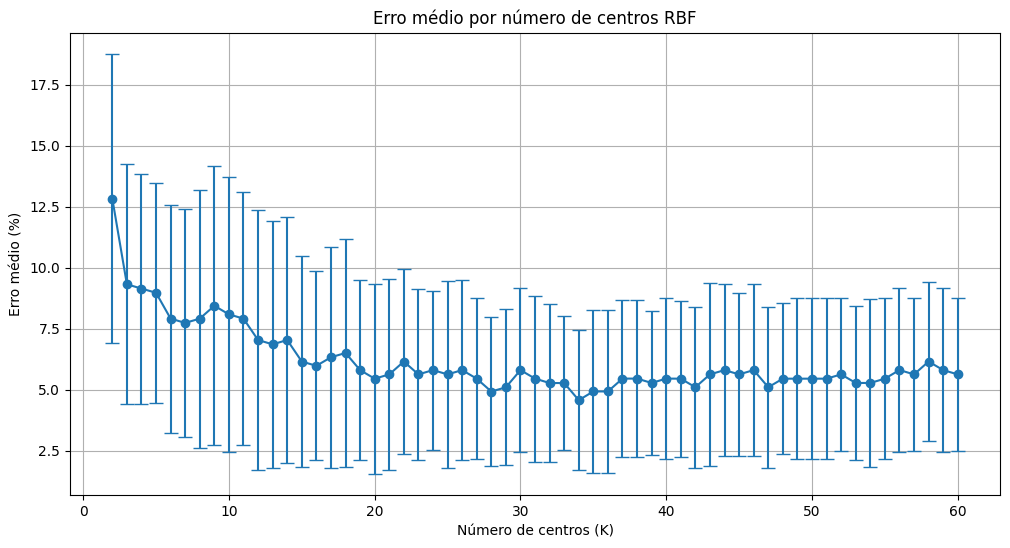


Melhor K: 34
Erro médio: 4.57%
Desvio padrão: 2.86%


In [ ]:
import matplotlib.pyplot as plt

medias = [resultados[k]['media'] for k in K_range]
desvios = [resultados[k]['desvio'] for k in K_range]

plt.figure(figsize=(12, 6))
plt.errorbar(list(K_range), medias, yerr=desvios, fmt='o-', capsize=5)
plt.xlabel('Número de centros (K)')
plt.ylabel('Erro médio (%)')
plt.title('Erro médio por número de centros RBF')
plt.grid(True)
plt.show()

# Encontrar o melhor K
melhor_k = min(K_range, key=lambda k: resultados[k]['media'])
print(f"\nMelhor K: {melhor_k}")
print(f"Erro médio: {resultados[melhor_k]['media']:.2f}%")
print(f"Desvio padrão: {resultados[melhor_k]['desvio']:.2f}%")